# Group Number:

# Student 1: Ryan Meghoe

# Student 2: Nikita Jain

# Student 3: Andrei Rykov

# Downloading Data and Preliminaries

In [3]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [4]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [5]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [6]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [7]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [8]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

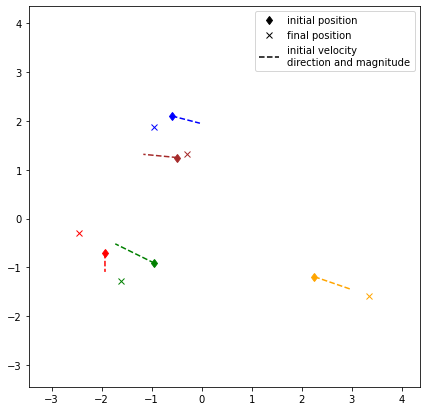

In [9]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [10]:
import torch

X_train = torch.cat((torch.tensor(positions_train[:,0,:,:]), torch.tensor(charges_train).squeeze(-1).unsqueeze(1)), dim=1)
X_train = torch.cat((X_train, torch.tensor(velocities_train).squeeze(1)), dim=1) # shape: (simulation id, parameters (x, y, c, v_x, v_y), particle id)
y_train = torch.tensor(positions_train[:,1:,:,:]) # shape: (simulation id, time (0.5, 1, 1.5), (x, y), particle id)

X_valid = torch.cat((torch.tensor(positions_valid[:,0,:,:]), torch.tensor(charges_valid).squeeze(-1).unsqueeze(1)), dim=1)
X_valid = torch.cat((X_valid, torch.tensor(velocities_valid).squeeze(1)), dim=1)
y_valid = torch.tensor(positions_valid[:,1:,:,:])

X_test = torch.cat((torch.tensor(positions_test[:,0,:,:]), torch.tensor(charges_test).squeeze(-1).unsqueeze(1)), dim=1)
X_test = torch.cat((X_test, torch.tensor(velocities_test).squeeze(1)), dim=1)
y_test = torch.tensor(positions_test[:,1:,:,:])

In [11]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

In [12]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Implementation

In [144]:
import torch
import torch.nn as nn

class MessageParsing(nn.Module):
    def __init__(self, set_size: int = 5, node_shape: int = 5, edge_shape: int = 1,
                 fau_output: int = 16, output_shape: int = 32,
                 device = torch.device('cpu')):
        super(MessageParsing, self).__init__()
        
        self.fau = nn.Sequential(nn.Linear(node_shape*2 + edge_shape, fau_output),
                                            nn.LeakyReLU())
        
        self.gamma = nn.Sequential(nn.Linear(fau_output + node_shape, output_shape),
                                   nn.LeakyReLU())
        
        self.fau_output = fau_output
        self.gamma_output = output_shape
        self.device = device
        
    def forward(self, x, edges):
        """
            x - input matrix of node features (batch_size, num_nodes, num_features)
            edge - input matrix of edge information (batch_size, num_nodes, num_nodes, num_features)
        """
        embeddings = torch.zeros((x.shape[0], x.shape[1], self.gamma_output)).to(self.device)
        
        for node in range(x.shape[1]):    
            temp = torch.cat([x[:,node,:].view(x.shape[0], 1, -1).repeat((1, x.shape[1] - 1, 1)),
                              x[:, list(set(range(x.shape[1])).difference({node})), :],
                              edges[:, node, list(set(range(x.shape[1])).difference({node})), :].view(x.shape[0], 
                                                                                                      x.shape[1]-1,
                                                                                                      -1)],
                            dim = -1)
            new = self.fau(temp)

            # aggregation function over dimension = 1 -- the whole neighborhood
            new = new.mean(axis = 1)
            #new = new.max(axis = 1).values
            
            new = torch.cat([x[:,node,:].view(x.shape[0], 1, -1),
                           new.view(x.shape[0], 1, -1)],
                           dim = 2)
            
            embeddings[:,node] = self.gamma(new).view(x.shape[0], -1)
        return embeddings

class ParticleModel(nn.Module):
    def __init__(self, input_shape: int = 5, set_size: int = 5, device = torch.device('cpu')):
        super(ParticleModel, self).__init__()
        self.iteration1 = MessageParsing(output_shape = 32, device=device)
        #self.iteration2 = MessageParsing(node_shape = 32, output_shape = 16, device = device)
        self.linear = nn.Sequential(nn.Linear(32, 2))
        self.device = device
           
    def forward(self, data):
        edges = torch.stack([torch.cdist(x_i, x_i) for x_i in data.swapaxes(1,2)], dim=0)\
                .view((data.shape[0], data.shape[1], data.shape[1], -1)).to(self.device)
        emb1 = self.iteration1(data.swapaxes(1,2), edges)
        #emb2 = self.iteration2(emb1, edges)
        out = self.linear(emb1)
        
        return out.swapaxes(1,2)

# Model Training

In [147]:
from tqdm import tqdm

class ParticleDistanceLoss(nn.Module):
    """
      The loss to calculate mean distance between predicted location of particle of each set.
      By defaul, Euclidean distance is set
    """

    def __init__(self, norm: float = 2):
        super(ParticleDistanceLoss, self).__init__()
        self.norm = norm

    def forward(self, input_set, target_set):
        """
            (batch_size, coordinates, set_size)
        """
        return (input_set - target_set).norm(p = self.norm, dim = 1).mean(axis = 1).mean()
        
        

class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 testing_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.testing_DataLoader = testing_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self, target_time):

        epoch_train_losses = []
        epoch_val_losses = []

        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}
        for epoch in tqdm(range(self.epochs)):
                 

            self.model.train()  # train mode

            train_losses=[]
            
            correct = 0
            length = 0
            for x, y in self.training_DataLoader:

                A, B = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                self.optimizer.zero_grad()  # zerograd the parameters

                loss = 0
                out = self.model(A)  # one forward pass

                loss += self.criterion(out, B[:,time_to_ind[target_time]])  # calculate loss
                
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
            
            epoch_train_losses.append(np.mean(train_losses))
            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            correct = 0
            length = 0
            for x,  y in self.validation_DataLoader:

                A,B = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                with torch.no_grad():
                    loss = 0
                    
                    out = self.model(A)  # one forward pass
                    loss += self.criterion(out, B[:,time_to_ind[target_time]])  # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            epoch_val_losses.append(np.mean(valid_losses))
                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

        return epoch_train_losses, epoch_val_losses
        
    def evaluate(self, target_time):

        self.model.eval()
        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}

        with torch.no_grad():
            loss = []
            length = 0
            for x,y in self.testing_DataLoader:
                
                A, B = x.float().to(self.device), y.float().to(self.device)
                out = self.model(A)
                loss.append(self.criterion(out, B[:,time_to_ind[target_time]]))
        print(f'Error: {np.mean(loss):.4f} for target time {target_time}',end=' ')

## Experiments

Using full training data

#### The max pooling aggregation of the node neighbourhood

In [143]:
times = [0.5, 1, 1.5]
time_to_ind = {0.5:0, 1:1, 1.5:2}

for time in times:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device=torch.device('cpu')

    model = ParticleModel(device = device).to(device)
    criterion = ParticleDistanceLoss(norm=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    TrainingProcedure = Trainer(model, 
                                device, 
                                criterion, 
                                optimizer,
                                train_dataloader,
                                valid_dataloader,
                                test_dataloader,
                                epochs = 20)

    train_loss, val_loss = TrainingProcedure.run_trainer(target_time=time)
    TrainingProcedure.evaluate(target_time=time)

  5%|████▏                                                                              | 1/20 [00:01<00:19,  1.01s/it]

EPOCH: 01/20 LOSS: 0.4487 VAL-LOSS: 0.2481


 10%|████████▎                                                                          | 2/20 [00:02<00:18,  1.00s/it]

EPOCH: 02/20 LOSS: 0.2022 VAL-LOSS: 0.1858


 15%|████████████▍                                                                      | 3/20 [00:02<00:16,  1.00it/s]

EPOCH: 03/20 LOSS: 0.1865 VAL-LOSS: 0.1804


 20%|████████████████▌                                                                  | 4/20 [00:03<00:15,  1.03it/s]

EPOCH: 04/20 LOSS: 0.1830 VAL-LOSS: 0.1850


 25%|████████████████████▊                                                              | 5/20 [00:04<00:14,  1.04it/s]

EPOCH: 05/20 LOSS: 0.1732 VAL-LOSS: 0.1604


 30%|████████████████████████▉                                                          | 6/20 [00:05<00:13,  1.01it/s]

EPOCH: 06/20 LOSS: 0.1636 VAL-LOSS: 0.1513


 35%|█████████████████████████████                                                      | 7/20 [00:06<00:12,  1.01it/s]

EPOCH: 07/20 LOSS: 0.1538 VAL-LOSS: 0.1439


 40%|█████████████████████████████████▏                                                 | 8/20 [00:07<00:11,  1.02it/s]

EPOCH: 08/20 LOSS: 0.1514 VAL-LOSS: 0.1530


 45%|█████████████████████████████████████▎                                             | 9/20 [00:08<00:10,  1.01it/s]

EPOCH: 09/20 LOSS: 0.1479 VAL-LOSS: 0.1482


 50%|█████████████████████████████████████████                                         | 10/20 [00:10<00:10,  1.04s/it]

EPOCH: 10/20 LOSS: 0.1439 VAL-LOSS: 0.1384


 55%|█████████████████████████████████████████████                                     | 11/20 [00:11<00:09,  1.06s/it]

EPOCH: 11/20 LOSS: 0.1430 VAL-LOSS: 0.1398


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:12<00:08,  1.09s/it]

EPOCH: 12/20 LOSS: 0.1400 VAL-LOSS: 0.1376


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:13<00:07,  1.06s/it]

EPOCH: 13/20 LOSS: 0.1399 VAL-LOSS: 0.1357


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:14<00:06,  1.10s/it]

EPOCH: 14/20 LOSS: 0.1365 VAL-LOSS: 0.1388


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:15<00:05,  1.09s/it]

EPOCH: 15/20 LOSS: 0.1370 VAL-LOSS: 0.1401


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:16<00:04,  1.09s/it]

EPOCH: 16/20 LOSS: 0.1363 VAL-LOSS: 0.1333


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:17<00:03,  1.13s/it]

EPOCH: 17/20 LOSS: 0.1340 VAL-LOSS: 0.1339


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:18<00:02,  1.10s/it]

EPOCH: 18/20 LOSS: 0.1352 VAL-LOSS: 0.1332


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:19<00:01,  1.09s/it]

EPOCH: 19/20 LOSS: 0.1346 VAL-LOSS: 0.1294


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.05s/it]


EPOCH: 20/20 LOSS: 0.1337 VAL-LOSS: 0.1265
Error: 0.1294 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:01<00:19,  1.03s/it]

EPOCH: 01/20 LOSS: 0.6294 VAL-LOSS: 0.3709


 10%|████████▎                                                                          | 2/20 [00:02<00:19,  1.06s/it]

EPOCH: 02/20 LOSS: 0.3556 VAL-LOSS: 0.3378


 15%|████████████▍                                                                      | 3/20 [00:03<00:18,  1.10s/it]

EPOCH: 03/20 LOSS: 0.3427 VAL-LOSS: 0.3356


 20%|████████████████▌                                                                  | 4/20 [00:04<00:19,  1.19s/it]

EPOCH: 04/20 LOSS: 0.3328 VAL-LOSS: 0.3337


 25%|████████████████████▊                                                              | 5/20 [00:05<00:17,  1.19s/it]

EPOCH: 05/20 LOSS: 0.3105 VAL-LOSS: 0.2944


 30%|████████████████████████▉                                                          | 6/20 [00:06<00:16,  1.19s/it]

EPOCH: 06/20 LOSS: 0.2948 VAL-LOSS: 0.2954


 35%|█████████████████████████████                                                      | 7/20 [00:08<00:15,  1.23s/it]

EPOCH: 07/20 LOSS: 0.2875 VAL-LOSS: 0.2935


 40%|█████████████████████████████████▏                                                 | 8/20 [00:09<00:14,  1.22s/it]

EPOCH: 08/20 LOSS: 0.2816 VAL-LOSS: 0.2691


 45%|█████████████████████████████████████▎                                             | 9/20 [00:10<00:13,  1.22s/it]

EPOCH: 09/20 LOSS: 0.2753 VAL-LOSS: 0.2619


 50%|█████████████████████████████████████████                                         | 10/20 [00:11<00:12,  1.22s/it]

EPOCH: 10/20 LOSS: 0.2751 VAL-LOSS: 0.2667


 55%|█████████████████████████████████████████████                                     | 11/20 [00:13<00:10,  1.20s/it]

EPOCH: 11/20 LOSS: 0.2699 VAL-LOSS: 0.2615


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:14<00:09,  1.19s/it]

EPOCH: 12/20 LOSS: 0.2668 VAL-LOSS: 0.2753


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:15<00:07,  1.12s/it]

EPOCH: 13/20 LOSS: 0.2697 VAL-LOSS: 0.2697


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:16<00:06,  1.09s/it]

EPOCH: 14/20 LOSS: 0.2652 VAL-LOSS: 0.2666


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:17<00:05,  1.11s/it]

EPOCH: 15/20 LOSS: 0.2651 VAL-LOSS: 0.2674


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:18<00:04,  1.14s/it]

EPOCH: 16/20 LOSS: 0.2619 VAL-LOSS: 0.2561


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:19<00:03,  1.12s/it]

EPOCH: 17/20 LOSS: 0.2631 VAL-LOSS: 0.2695


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:20<00:02,  1.11s/it]

EPOCH: 18/20 LOSS: 0.2615 VAL-LOSS: 0.2585


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:21<00:01,  1.06s/it]

EPOCH: 19/20 LOSS: 0.2608 VAL-LOSS: 0.2531


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.13s/it]


EPOCH: 20/20 LOSS: 0.2570 VAL-LOSS: 0.2530
Error: 0.2569 for target time 1 

  5%|████▏                                                                              | 1/20 [00:00<00:18,  1.00it/s]

EPOCH: 01/20 LOSS: 0.7802 VAL-LOSS: 0.5582


 10%|████████▎                                                                          | 2/20 [00:02<00:18,  1.00s/it]

EPOCH: 02/20 LOSS: 0.5167 VAL-LOSS: 0.4990


 15%|████████████▍                                                                      | 3/20 [00:03<00:17,  1.02s/it]

EPOCH: 03/20 LOSS: 0.4506 VAL-LOSS: 0.4393


 20%|████████████████▌                                                                  | 4/20 [00:04<00:16,  1.04s/it]

EPOCH: 04/20 LOSS: 0.4429 VAL-LOSS: 0.4468


 25%|████████████████████▊                                                              | 5/20 [00:05<00:15,  1.01s/it]

EPOCH: 05/20 LOSS: 0.4389 VAL-LOSS: 0.4306


 30%|████████████████████████▉                                                          | 6/20 [00:06<00:14,  1.01s/it]

EPOCH: 06/20 LOSS: 0.4294 VAL-LOSS: 0.4324


 35%|█████████████████████████████                                                      | 7/20 [00:07<00:13,  1.01s/it]

EPOCH: 07/20 LOSS: 0.4248 VAL-LOSS: 0.4369


 40%|█████████████████████████████████▏                                                 | 8/20 [00:08<00:12,  1.01s/it]

EPOCH: 08/20 LOSS: 0.4232 VAL-LOSS: 0.4259


 45%|█████████████████████████████████████▎                                             | 9/20 [00:09<00:11,  1.01s/it]

EPOCH: 09/20 LOSS: 0.4182 VAL-LOSS: 0.4129


 50%|█████████████████████████████████████████                                         | 10/20 [00:10<00:10,  1.03s/it]

EPOCH: 10/20 LOSS: 0.4142 VAL-LOSS: 0.4164


 55%|█████████████████████████████████████████████                                     | 11/20 [00:11<00:09,  1.06s/it]

EPOCH: 11/20 LOSS: 0.4151 VAL-LOSS: 0.4244


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:12<00:08,  1.05s/it]

EPOCH: 12/20 LOSS: 0.4146 VAL-LOSS: 0.4071


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:13<00:07,  1.01s/it]

EPOCH: 13/20 LOSS: 0.4107 VAL-LOSS: 0.4058


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:14<00:06,  1.04s/it]

EPOCH: 14/20 LOSS: 0.4113 VAL-LOSS: 0.4151


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:15<00:05,  1.04s/it]

EPOCH: 15/20 LOSS: 0.4053 VAL-LOSS: 0.4058


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:16<00:04,  1.04s/it]

EPOCH: 16/20 LOSS: 0.4060 VAL-LOSS: 0.3982


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:17<00:03,  1.04s/it]

EPOCH: 17/20 LOSS: 0.4083 VAL-LOSS: 0.4092


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:18<00:02,  1.05s/it]

EPOCH: 18/20 LOSS: 0.4056 VAL-LOSS: 0.4082


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:19<00:01,  1.03s/it]

EPOCH: 19/20 LOSS: 0.3983 VAL-LOSS: 0.4011


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.03s/it]

EPOCH: 20/20 LOSS: 0.4007 VAL-LOSS: 0.3927
Error: 0.3994 for target time 1.5 

#### The mean aggregation of the node neighbourhood

In [145]:
times = [0.5, 1, 1.5]
time_to_ind = {0.5:0, 1:1, 1.5:2}

for time in times:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device=torch.device('cpu')

    model = ParticleModel(device = device).to(device)
    criterion = ParticleDistanceLoss(norm=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    TrainingProcedure = Trainer(model, 
                                device, 
                                criterion, 
                                optimizer,
                                train_dataloader,
                                valid_dataloader,
                                test_dataloader,
                                epochs = 20)

    train_loss, val_loss = TrainingProcedure.run_trainer(target_time=time)
    TrainingProcedure.evaluate(target_time=time)

  5%|████▏                                                                              | 1/20 [00:00<00:15,  1.24it/s]

EPOCH: 01/20 LOSS: 0.4045 VAL-LOSS: 0.1867


 10%|████████▎                                                                          | 2/20 [00:01<00:14,  1.21it/s]

EPOCH: 02/20 LOSS: 0.1734 VAL-LOSS: 0.1833


 15%|████████████▍                                                                      | 3/20 [00:02<00:14,  1.20it/s]

EPOCH: 03/20 LOSS: 0.1629 VAL-LOSS: 0.1700


 20%|████████████████▌                                                                  | 4/20 [00:03<00:13,  1.19it/s]

EPOCH: 04/20 LOSS: 0.1610 VAL-LOSS: 0.1542


 25%|████████████████████▊                                                              | 5/20 [00:04<00:12,  1.21it/s]

EPOCH: 05/20 LOSS: 0.1547 VAL-LOSS: 0.1666


 30%|████████████████████████▉                                                          | 6/20 [00:04<00:11,  1.22it/s]

EPOCH: 06/20 LOSS: 0.1484 VAL-LOSS: 0.1419


 35%|█████████████████████████████                                                      | 7/20 [00:05<00:10,  1.22it/s]

EPOCH: 07/20 LOSS: 0.1436 VAL-LOSS: 0.1390


 40%|█████████████████████████████████▏                                                 | 8/20 [00:06<00:09,  1.23it/s]

EPOCH: 08/20 LOSS: 0.1442 VAL-LOSS: 0.1332


 45%|█████████████████████████████████████▎                                             | 9/20 [00:07<00:08,  1.23it/s]

EPOCH: 09/20 LOSS: 0.1440 VAL-LOSS: 0.1443


 50%|█████████████████████████████████████████                                         | 10/20 [00:08<00:08,  1.23it/s]

EPOCH: 10/20 LOSS: 0.1448 VAL-LOSS: 0.1396


 55%|█████████████████████████████████████████████                                     | 11/20 [00:09<00:07,  1.23it/s]

EPOCH: 11/20 LOSS: 0.1444 VAL-LOSS: 0.1358


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:09<00:06,  1.22it/s]

EPOCH: 12/20 LOSS: 0.1406 VAL-LOSS: 0.1446


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:10<00:05,  1.22it/s]

EPOCH: 13/20 LOSS: 0.1432 VAL-LOSS: 0.1521


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:11<00:04,  1.21it/s]

EPOCH: 14/20 LOSS: 0.1439 VAL-LOSS: 0.1487


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:12<00:04,  1.21it/s]

EPOCH: 15/20 LOSS: 0.1437 VAL-LOSS: 0.1508


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:13<00:03,  1.20it/s]

EPOCH: 16/20 LOSS: 0.1411 VAL-LOSS: 0.1391


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:14<00:02,  1.20it/s]

EPOCH: 17/20 LOSS: 0.1423 VAL-LOSS: 0.1527


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:14<00:01,  1.21it/s]

EPOCH: 18/20 LOSS: 0.1410 VAL-LOSS: 0.1437


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:15<00:00,  1.22it/s]

EPOCH: 19/20 LOSS: 0.1409 VAL-LOSS: 0.1343


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.22it/s]


EPOCH: 20/20 LOSS: 0.1400 VAL-LOSS: 0.1599
Error: 0.1620 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:00<00:15,  1.25it/s]

EPOCH: 01/20 LOSS: 0.6448 VAL-LOSS: 0.3830


 10%|████████▎                                                                          | 2/20 [00:01<00:14,  1.25it/s]

EPOCH: 02/20 LOSS: 0.3524 VAL-LOSS: 0.3287


 15%|████████████▍                                                                      | 3/20 [00:02<00:13,  1.24it/s]

EPOCH: 03/20 LOSS: 0.3239 VAL-LOSS: 0.3197


 20%|████████████████▌                                                                  | 4/20 [00:03<00:12,  1.24it/s]

EPOCH: 04/20 LOSS: 0.3120 VAL-LOSS: 0.3088


 25%|████████████████████▊                                                              | 5/20 [00:04<00:12,  1.23it/s]

EPOCH: 05/20 LOSS: 0.3037 VAL-LOSS: 0.2985


 30%|████████████████████████▉                                                          | 6/20 [00:04<00:11,  1.23it/s]

EPOCH: 06/20 LOSS: 0.2944 VAL-LOSS: 0.2843


 35%|█████████████████████████████                                                      | 7/20 [00:05<00:10,  1.24it/s]

EPOCH: 07/20 LOSS: 0.2883 VAL-LOSS: 0.3007


 40%|█████████████████████████████████▏                                                 | 8/20 [00:06<00:09,  1.24it/s]

EPOCH: 08/20 LOSS: 0.2872 VAL-LOSS: 0.2922


 45%|█████████████████████████████████████▎                                             | 9/20 [00:07<00:08,  1.24it/s]

EPOCH: 09/20 LOSS: 0.2848 VAL-LOSS: 0.2880


 50%|█████████████████████████████████████████                                         | 10/20 [00:08<00:08,  1.24it/s]

EPOCH: 10/20 LOSS: 0.2843 VAL-LOSS: 0.2771


 55%|█████████████████████████████████████████████                                     | 11/20 [00:08<00:07,  1.24it/s]

EPOCH: 11/20 LOSS: 0.2796 VAL-LOSS: 0.2816


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:09<00:06,  1.24it/s]

EPOCH: 12/20 LOSS: 0.2813 VAL-LOSS: 0.2882


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:10<00:05,  1.24it/s]

EPOCH: 13/20 LOSS: 0.2800 VAL-LOSS: 0.2854


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:11<00:04,  1.24it/s]

EPOCH: 14/20 LOSS: 0.2799 VAL-LOSS: 0.2824


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:12<00:04,  1.24it/s]

EPOCH: 15/20 LOSS: 0.2776 VAL-LOSS: 0.2719


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:12<00:03,  1.24it/s]

EPOCH: 16/20 LOSS: 0.2758 VAL-LOSS: 0.2772


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:13<00:02,  1.24it/s]

EPOCH: 17/20 LOSS: 0.2759 VAL-LOSS: 0.2745


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:14<00:01,  1.24it/s]

EPOCH: 18/20 LOSS: 0.2746 VAL-LOSS: 0.2708


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:15<00:00,  1.24it/s]

EPOCH: 19/20 LOSS: 0.2739 VAL-LOSS: 0.2646


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.23it/s]


EPOCH: 20/20 LOSS: 0.2705 VAL-LOSS: 0.2715
Error: 0.2768 for target time 1 

  5%|████▏                                                                              | 1/20 [00:00<00:15,  1.23it/s]

EPOCH: 01/20 LOSS: 0.8188 VAL-LOSS: 0.5664


 10%|████████▎                                                                          | 2/20 [00:01<00:14,  1.21it/s]

EPOCH: 02/20 LOSS: 0.5466 VAL-LOSS: 0.5177


 15%|████████████▍                                                                      | 3/20 [00:02<00:14,  1.20it/s]

EPOCH: 03/20 LOSS: 0.4688 VAL-LOSS: 0.4416


 20%|████████████████▌                                                                  | 4/20 [00:03<00:13,  1.21it/s]

EPOCH: 04/20 LOSS: 0.4455 VAL-LOSS: 0.4417


 25%|████████████████████▊                                                              | 5/20 [00:04<00:12,  1.20it/s]

EPOCH: 05/20 LOSS: 0.4378 VAL-LOSS: 0.4371


 30%|████████████████████████▉                                                          | 6/20 [00:04<00:11,  1.19it/s]

EPOCH: 06/20 LOSS: 0.4350 VAL-LOSS: 0.4377


 35%|█████████████████████████████                                                      | 7/20 [00:05<00:10,  1.19it/s]

EPOCH: 07/20 LOSS: 0.4266 VAL-LOSS: 0.4235


 40%|█████████████████████████████████▏                                                 | 8/20 [00:06<00:10,  1.20it/s]

EPOCH: 08/20 LOSS: 0.4216 VAL-LOSS: 0.4325


 45%|█████████████████████████████████████▎                                             | 9/20 [00:07<00:09,  1.22it/s]

EPOCH: 09/20 LOSS: 0.4230 VAL-LOSS: 0.4151


 50%|█████████████████████████████████████████                                         | 10/20 [00:08<00:08,  1.23it/s]

EPOCH: 10/20 LOSS: 0.4190 VAL-LOSS: 0.4166


 55%|█████████████████████████████████████████████                                     | 11/20 [00:09<00:07,  1.22it/s]

EPOCH: 11/20 LOSS: 0.4163 VAL-LOSS: 0.4245


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:09<00:06,  1.22it/s]

EPOCH: 12/20 LOSS: 0.4129 VAL-LOSS: 0.4330


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:10<00:05,  1.23it/s]

EPOCH: 13/20 LOSS: 0.4085 VAL-LOSS: 0.4008


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:11<00:04,  1.23it/s]

EPOCH: 14/20 LOSS: 0.4063 VAL-LOSS: 0.3977


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:12<00:04,  1.23it/s]

EPOCH: 15/20 LOSS: 0.4039 VAL-LOSS: 0.3983


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:13<00:03,  1.24it/s]

EPOCH: 16/20 LOSS: 0.4031 VAL-LOSS: 0.4179


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:13<00:02,  1.25it/s]

EPOCH: 17/20 LOSS: 0.4029 VAL-LOSS: 0.3993


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:14<00:01,  1.25it/s]

EPOCH: 18/20 LOSS: 0.4020 VAL-LOSS: 0.4027


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:15<00:00,  1.25it/s]

EPOCH: 19/20 LOSS: 0.3993 VAL-LOSS: 0.3957


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.23it/s]

EPOCH: 20/20 LOSS: 0.3970 VAL-LOSS: 0.3972
Error: 0.4037 for target time 1.5 

In [146]:
# (simulation id, time (0.5, 1, 1.5), (x, y), particle id)
# (simulation id, parameters (x, y, c, v_x, v_y), particle id)

def predict(x, time):
    predictions = torch.cat([x[:,0,:]+ time*x[:,-2,:], x[:,1,:] + time*x[:,-1,:]], dim = 1)
    return predictions.view((x.shape[0], -1, x.shape[-1]))

loss_f = ParticleDistanceLoss(norm = 2)

times = [0.5, 1, 1.5]
time_to_ind = {0.5:0, 1:1, 1.5:2}
loss = [[],[],[]]
for x,y in test_dataloader:
    for time in times:                    
        A, B = x.float(), y.float()
        out = predict(A, time)
        loss[time_to_ind[time]].append(loss_f(out, B[:,time_to_ind[time]]))

print(f'Mean of mean distance (Eudclidean) for 0.5 seconds: {np.mean(loss[0]):.4f}; for 1.0 second: {np.mean(loss[1]):.4f}, for 1.5 seconds: {np.mean(loss[2]):.4f}',end=' ')

Mean of mean distance (Eudclidean) for 0.5 seconds: 0.1682; for 1.0 second: 0.3932, for 1.5 seconds: 0.6314 

#### In the end, we got next results:

These are the results on the test set, mean values of Mean Euclidean distance per particle set

| Model                | t=0.5  | t=1.0   | t=1.5  |
|----------------------|--------|--------|--------|
| Max Pooling          | **0.1294** | **0.2569** | **0.3994** |
| Mean                 | 0.1620 | 0.2768 | 0.4037 |
| Linear Interpolation | 0.1682 | 0.3932 | 0.6314 |

# Evaluation

In [ ]:
#todo